
## Grundwasservorhersage mittels eines Decision Trees, Brandenburg 

> author: Anne Schwind
> 
> area: Brandenburg, Stolpe BB 30400591
> 
> date: 26.08.2024


In [1]:
# First, let's import all the needed libraries. 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split  
from sklearn import metrics                            
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score

### Datenverarbeitung 

Für dieses Beispiel verwenden wir eine wöchentliche Daten verschiedener hydrometeorlogischer Größen aus dem Projekt **"HYRAS - Hydrometeorologische Rasterdaten"** aus Brandenburg. 

Die Daten wurden heruntergeladen vom LfU - Landesamt für Umwelt Brandenburg über [diesen Link](http://maps.brandenburg.de/WebOffice/?project=GWM_www_WO). 

Stand der Daten: 2018

Nun müssen wir die Daten der Grundwasservorhersage einlesen und organisieren. Das bedeutet, dass wir die Daten einlesen, ungenutzte Spalten entfernen und die Spalten für besser Übersichtlichkeit unbenennen. Anschließend setzen wir das Datum als Indexspalte.

In [2]:
import pandas as pd

url = "https://tubcloud.tu-berlin.de/s/6cBLzd7fGDasDFz/download?path=%2F&files=BB_30400591_weeklyData_HYRAS_GWData.csv&downloadStartSecret=jscl9uomzpq"

data_raw = pd.read_csv(url)
   
data_raw

HTTPError: HTTP Error 404: Not Found

In [18]:
df = data_raw.drop(columns=["Unnamed: 0"])
df

,Date,pr,tas,GWL
0,1990-01-01,0.6,-1.771429,39.75
1,1990-01-08,0.4,1.871429,39.79
2,1990-01-15,2.5,5.700000,39.82
3,1990-01-22,16.0,6.242858,39.85
4,1990-01-29,2.3,6.457143,39.90
...,...,...,...,...
830,2005-11-28,6.0,1.242857,40.06
831,2005-12-05,0.7,2.128571,40.07
832,2005-12-12,11.9,2.442857,40.06
833,2005-12-19,5.0,3.657143,40.07


In [19]:
df = df.rename(columns={"Date": "Datum",
                        "pr": "Niederschlag",
                        "tas": "Temperatur",
                        "GWL": "Grundwasserhöhe"})
df

,Datum,Niederschlag,Temperatur,Grundwasserhöhe
0,1990-01-01,0.6,-1.771429,39.75
1,1990-01-08,0.4,1.871429,39.79
2,1990-01-15,2.5,5.700000,39.82
3,1990-01-22,16.0,6.242858,39.85
4,1990-01-29,2.3,6.457143,39.90
...,...,...,...,...
830,2005-11-28,6.0,1.242857,40.06
831,2005-12-05,0.7,2.128571,40.07
832,2005-12-12,11.9,2.442857,40.06
833,2005-12-19,5.0,3.657143,40.07


In [20]:
df = df.set_index('Datum')

df

,Niederschlag,Temperatur,Grundwasserhöhe
Datum,,,
1990-01-01,0.6,-1.771429,39.75
1990-01-08,0.4,1.871429,39.79
1990-01-15,2.5,5.700000,39.82
1990-01-22,16.0,6.242858,39.85
1990-01-29,2.3,6.457143,39.90
...,...,...,...
2005-11-28,6.0,1.242857,40.06
2005-12-05,0.7,2.128571,40.07
2005-12-12,11.9,2.442857,40.06


### Daten prozessieren

Durch den *Pairplot* (oder auch Scatterplot) können wir die Struktur den Datenbasis und der Verteilung der Daten besser verstehen. So kann zum Beispiel festgestell werden, ob die Daten miteinander korrelieren.

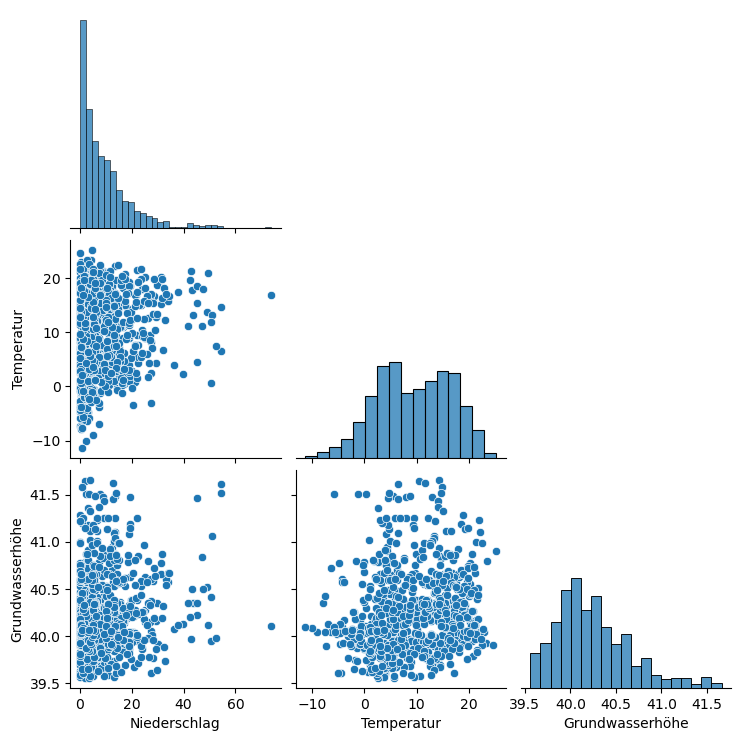

In [21]:
sns.pairplot(df, corner=True)
plt.show()

Es ist erkennbar, dass in den vorliegenden Daten keine **starken linearen Korrelationen** zwischen den Variablen zu erkennen sind.

Damit wir keine ungenauen Werte erhalten, wollen wir alle fehlenden Daten löschen. Allerdings zeigt der folgende Befehl, dass es keine Spalte mit fehlenden Werten gibt.

In [22]:
df.isnull().sum()

Niederschlag       0
Temperatur         0
Grundwasserhöhe    0
dtype: int64

Nun können wir uns die Daten einmal beschreiben lassen und alle drei Variablen plotten lassen, um ein besseres Bild von den Daten zu erhalten.

In [23]:
df.describe()

,Niederschlag,Temperatur,Grundwasserhöhe
count,835.000000,835.000000,835.000000
mean,9.368503,9.425144,40.245162
std,9.986305,7.085398,0.412379
min,0.000000,-11.342857,39.560000
25%,2.200000,4.007143,39.950000
50%,6.100000,9.500000,40.170000
75%,13.300000,15.292858,40.475000
max,73.700000,25.199999,41.660000


<Axes: xlabel='Datum'>

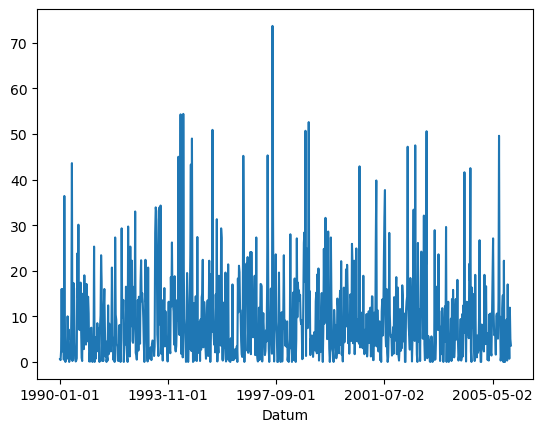

In [24]:
df['Niederschlag'].plot()

<Axes: xlabel='Datum'>

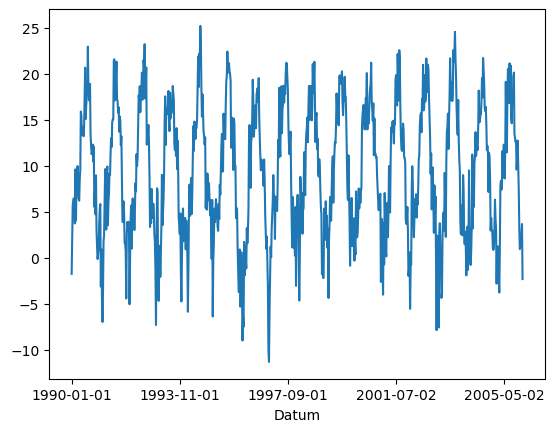

In [25]:
df['Temperatur'].plot()

<Axes: xlabel='Datum'>

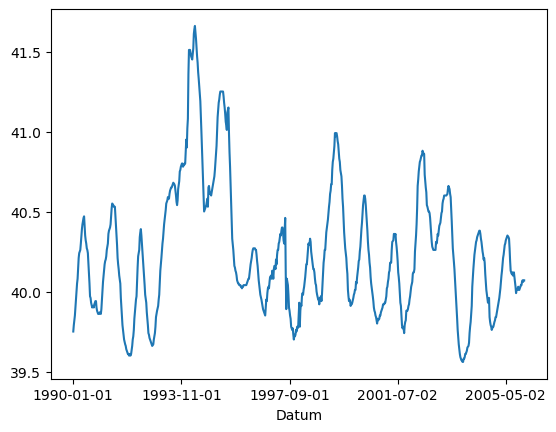

In [26]:
df['Grundwasserhöhe'].plot()

### Zusätzliche Features

Im nächsten Schritt sollen die Datern erweitert werden und die neue Variable *"Niederschlagtimelag"* hinzugefügt werden. 

Die Variable *"Niederschlagtimelag"* fasst jeweils den den Niederschlag der Woche davor und der aktuellen Woche zusammen. Sie stellt also die Summe des Niederschlags über einen gleitenden Zeitraum von zwei Wochen dar.  

In [28]:
df['Niederschlag']['1990-01-01':'2005-12-26']

Datum
1990-01-01     0.6
1990-01-08     0.4
1990-01-15     2.5
1990-01-22    16.0
1990-01-29     2.3
              ... 
2005-11-28     6.0
2005-12-05     0.7
2005-12-12    11.9
2005-12-19     5.0
2005-12-26     3.6
Name: Niederschlag, Length: 835, dtype: float64

In [29]:
df_Niederschlag_3WochenSumme = df['Niederschlag'].rolling(window=2, center=True).sum()

df_Niederschlag_3WochenSumme

Datum
1990-01-01     NaN
1990-01-08     1.0
1990-01-15     2.9
1990-01-22    18.5
1990-01-29    18.3
              ... 
2005-11-28     9.3
2005-12-05     6.7
2005-12-12    12.6
2005-12-19    16.9
2005-12-26     8.6
Name: Niederschlag, Length: 835, dtype: float64

Die Summe des Niederschlags der letzen und der aktuellen Woche wird nun als neue Spalte *"Niederschlagtimelag"* in den Datensatz aufgenommen.

In [30]:
df['Niederschlagtimelag'] = df_Niederschlag_3WochenSumme 

df

,Niederschlag,Temperatur,Grundwasserhöhe,Niederschlagtimelag
Datum,,,,
1990-01-01,0.6,-1.771429,39.75,NaN
1990-01-08,0.4,1.871429,39.79,1.0
1990-01-15,2.5,5.700000,39.82,2.9
1990-01-22,16.0,6.242858,39.85,18.5
1990-01-29,2.3,6.457143,39.90,18.3
...,...,...,...,...
2005-11-28,6.0,1.242857,40.06,9.3
2005-12-05,0.7,2.128571,40.07,6.7
2005-12-12,11.9,2.442857,40.06,12.6


Allerdings hat nun die erste Zeile fehlende Daten, da es für das erste Datum keine Messung davor gibt, die im *"Niederschlagtimelag"* mit der aktuellen Messung zusammengefasst werden kann.

Die erste Zeile kann jedoch gelöscht werden, da wir eine ausreichend große Datenbasis haben.

In [31]:
df.isnull().sum()

Niederschlag           0
Temperatur             0
Grundwasserhöhe        0
Niederschlagtimelag    1
dtype: int64

In [32]:
df.dropna(axis=0, inplace=True)
df

,Niederschlag,Temperatur,Grundwasserhöhe,Niederschlagtimelag
Datum,,,,
1990-01-08,0.4,1.871429,39.79,1.0
1990-01-15,2.5,5.700000,39.82,2.9
1990-01-22,16.0,6.242858,39.85,18.5
1990-01-29,2.3,6.457143,39.90,18.3
1990-02-05,6.7,6.000000,39.95,9.0
...,...,...,...,...
2005-11-28,6.0,1.242857,40.06,9.3
2005-12-05,0.7,2.128571,40.07,6.7
2005-12-12,11.9,2.442857,40.06,12.6


***

### Model: Decision Tree

Nun wollen wir einen Decision Tree (bzw. Entscheidungsbaum) erstellen. Dieser kann mit unterschiedliechen Tiefen, das heißt Anzahl an vertikal aufeinaner folgenden Verzweigungen erstellt werden. Die Tiefe des Baums spielt eine entscheidende Rolle für die Leistung und die Eigenschaften des Modells. So kann ein Decision Tree mit größerer Anzahl an Tiefen komplexere Daten darstellen. 

**Im Allgemeinen gilt:**

**Je mehr Tiefen der Decision Tree hat, desto höher ist die Gefahr von Overfitting.
Je weniger Tiefen der Decision Tree hat, desto höher ist die Gefahr von Underfitting.**

Wir wollen den Decision Tree mit unterschiedlichen Tiefen erstellen, um ein optimales Ergebnis zu erzielen.

Zunächst werden dafür die Daten in Features und Target Variablen unterschieden.

In [33]:
feature_cols = ['Niederschlag', 'Temperatur']
X = df[feature_cols] # Features
y = df.Grundwasserhöhe # Target variable

Anschließend unterteilen wir die Datenbasis in einen Trainingsdatensatz und einen Testdatensatz. Dabei nutzen wird das Verhältnis 70 zu 30. 

Das bedeutet, dass der Trainingsdatensatz 70% der Datenbasis enthalten soll und der Testdatensatz 30% der Daten enthalten soll.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Zur Auswertung der Decision Trees mit unterschiedlichen Tiefen nutzen wir den **Mean Squared Error (MSE)**. 

Der MSE misst den durchschnittlichen quadratischen Fehler zwischen den durch das Regressionsmodell vorhergesagten Werten und den tatsächlichen Werten im Testdatensatz. Er test also wie gut das Regressionsmodell die Daten beschreibt. 

**Im Allgmeinen gilt: Je kleiner der MSE, desto besser passt das erstellte Modell zu den Daten.**

#### Decision Tree mit der Tiefe 2

Unsere Zielvariable der Grundwasserhöhe ist eine kontinuierliche Variable, deswegen können wir im Folgenden den folgenden Decision Tree Regressor verwenden.

In [69]:
model = DecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

In [70]:
y_pred = model.predict(X_test)

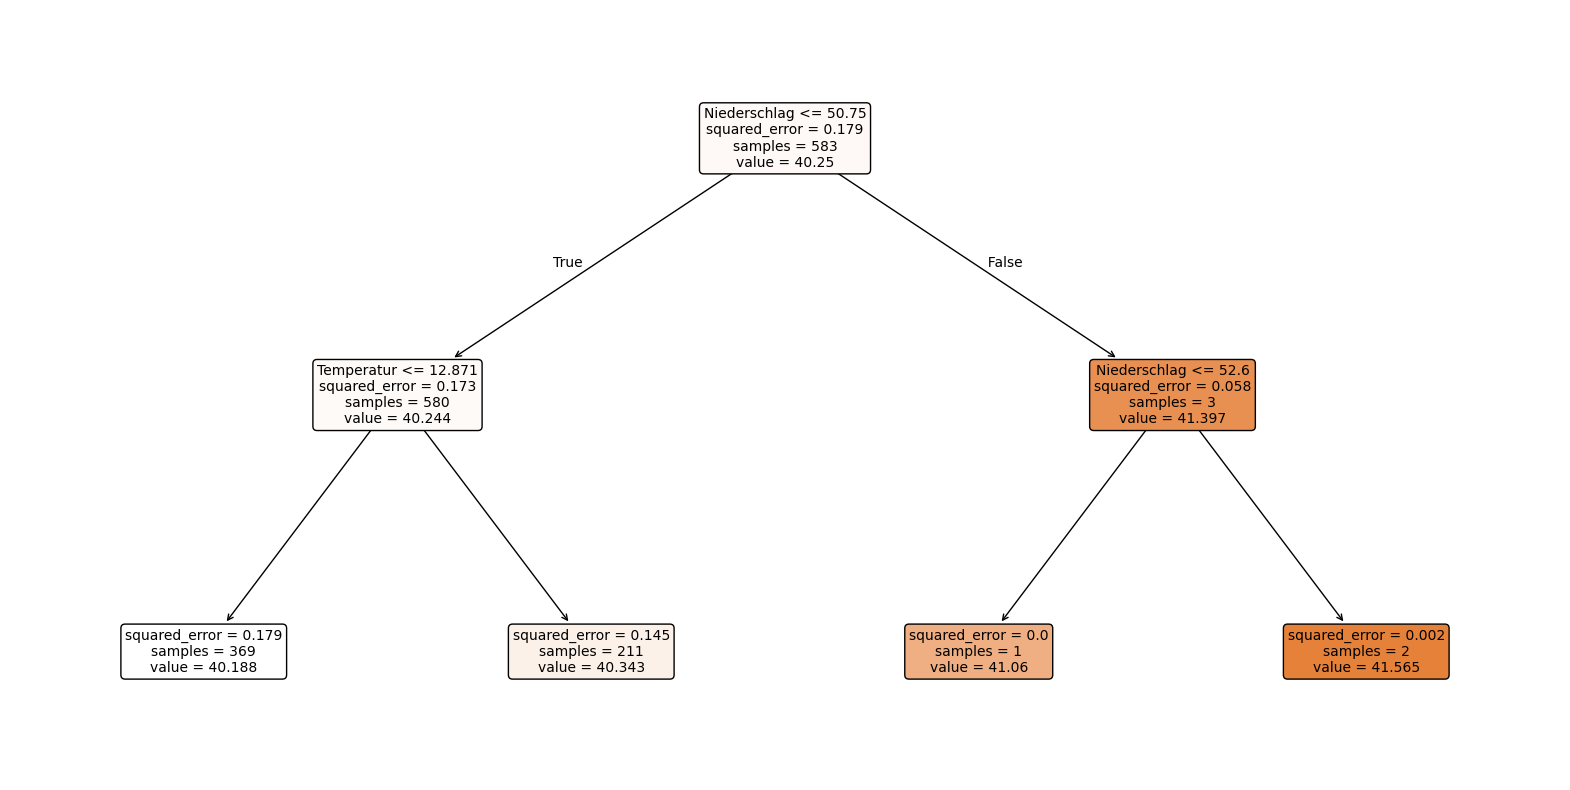

In [71]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()

In [72]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.16105546585567312


Der Decision Tree mit der Tiefe 2 sagt aus:

- Beispiel: Wenn der Niederschlag niedriger oder gleich 50.75 und die Temperatur niedriger oder gleich 12.871 Grad ist, dann liegt der Grundwasserspiegel bei rund 40.188.
- Die Unterteilung ist hier noch sehr ungenau, da von 583 Daten für ganze 580 Daten es zutrifft, dass der Niederschlag niedriger als 50.75 ist.
- Ein insgesamter MSE von 0.161 ist bereits ein ziemlich gutes Ergebnis.
- Bei den unteren beiden linken Abzweiungen ist der MSE höher, da hier die sample-Anzahl deutlich höher ist und somit ein größerer Datensatz berücksichtigt wird.

Insgesamt könnte die Unterteilung und der Decision Tree besser sein, weshalb wir im nächsten Schritt eine größere Tiefe verwenden.

#### Decision Tree mit der Tiefe 3

In [73]:
model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [74]:
y_pred = model.predict(X_test)

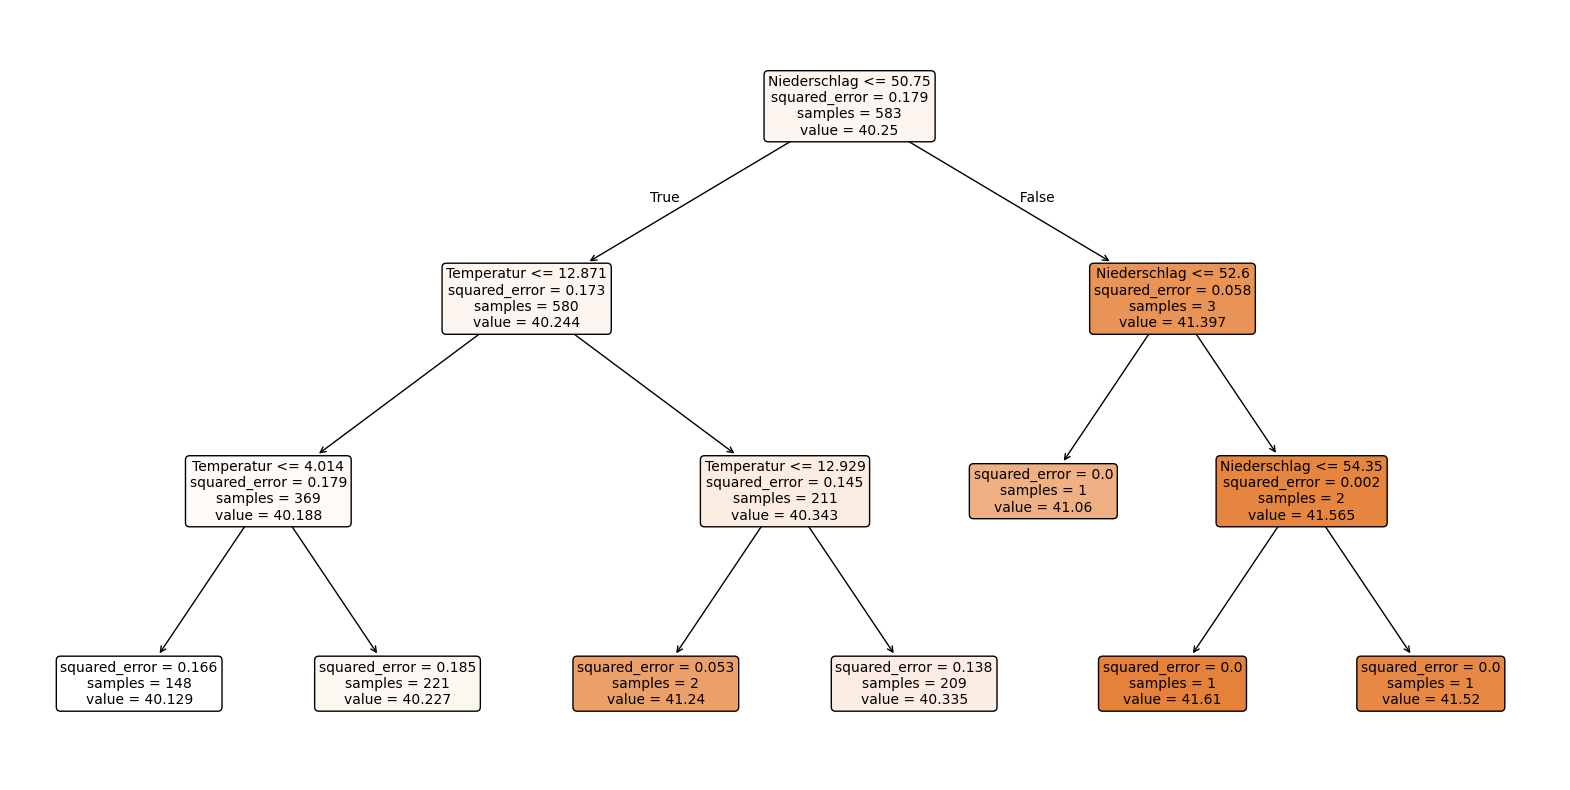

In [75]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()

In [76]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.1635600972018598


Der Decision Tree mit der Tiefe 3 sagt aus:

- Dadurch, dass eine Ebene hinzukommt, kann eine genauere Unterteilung vorgenommen werden.
- In der ersten Unterteilung erfüllen noch immer 580 von 583 Daten das Kriterium, jedoch werden die im nächsten Schritt nochmal genauer in 4 verschiedene Temperaturabschnitte unterteilt.
- Der insgesamte MSE von 0.163 ist höher als in dem letzten Decision Tree.
- Die einzelnen MSE sind teilweise auch höher als in dem Decision Tree mit der Tiefe 2, dennoch ist der Decision Tree mit der Tiefe 3 aussagekräftiger.

#### Decision Tree mit der Tiefe 4

In [77]:
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [78]:
y_pred = model.predict(X_test)

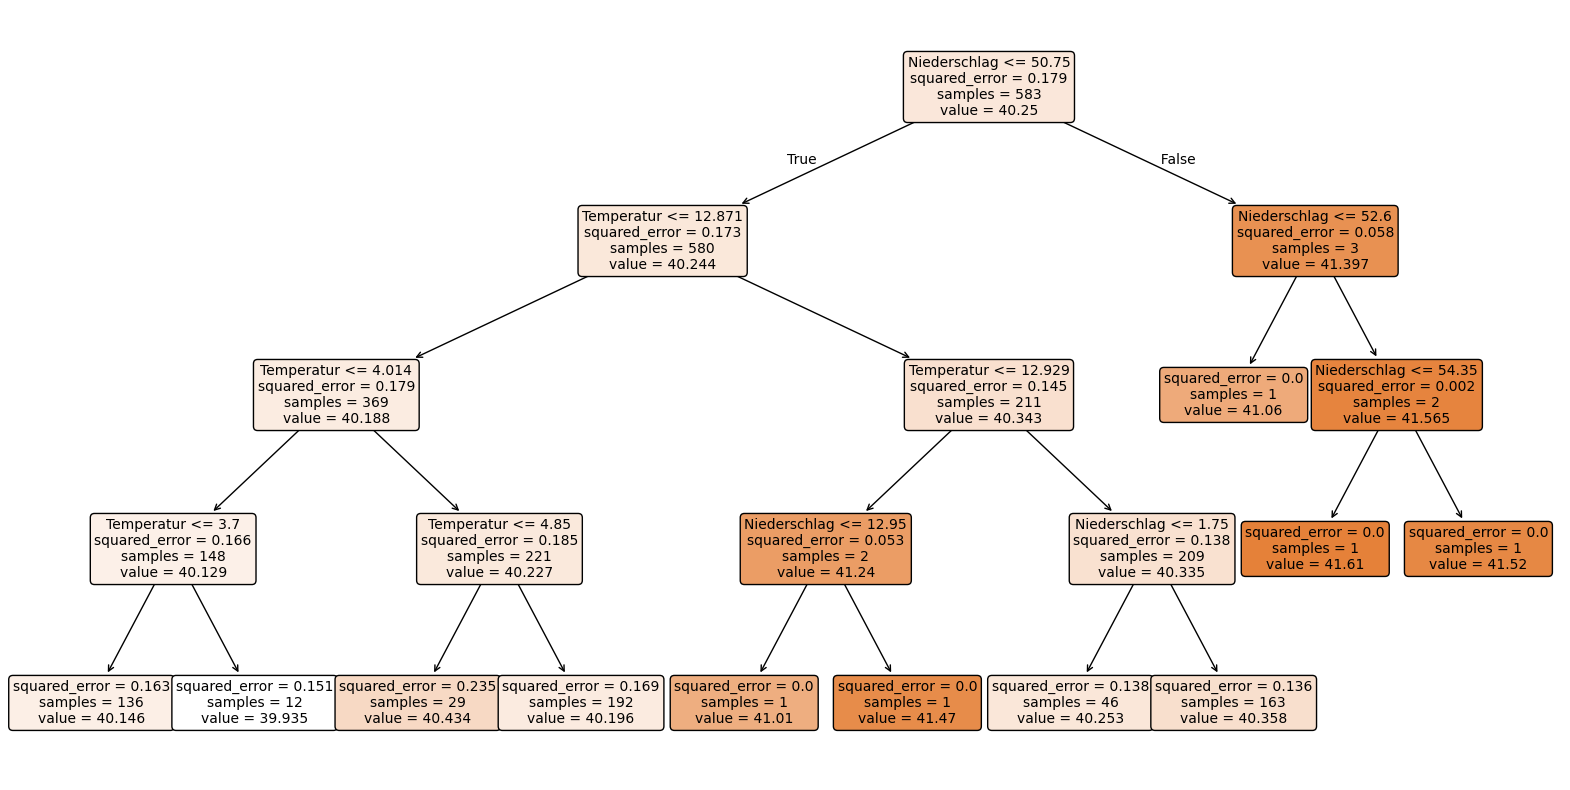

In [79]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()

In [80]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.16447223760774984


Der Decision Tree mit der Tiefe 4 sagt aus:

- Durch die weitere Unterteilung werden noch genauere Ergebnisse mit gerineren sample-Anzahlen deutlich.
- Die Grundwasserhöhen liegen alle relativ nah beieinander, weshalb auch eine geringe Unterscheidung wichtig sein kann.
- Der insgesamte MSE von 0.164 bleibt nahezu unverändert.

### Decision Tree mit 'Niederschlagtimelag' - Variable

Wir wollen herausfinden, wie sich der Niederschlag auf das Grundwasser auswirkt. Dafür ist es durchaus sinnvoll in die Berechnungen den Niederschlag von dieser Woche als auch der vorherigen Woche zu berücksichtigen. Der Niederschlag braucht je nach Beschaffenheit Zeit, um in das Grundwasser zu versickern und kann nicht bereits nach einer Woche im Grundwasser nachgewiesen werden.

Wir wollen daher nun einen Decision Tree mit der zuvor erstellten Variable *'Niederschlagtimelag'* erstellen.

Dafür müssen wir zunächst neue Feature und Target Variablen bestimmen und das Modell darauf trainieren.

In [83]:
feature_cols = ['Niederschlagtimelag', 'Temperatur']
X = df[feature_cols] # Features
y = df.Grundwasserhöhe # Target variable

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Nun erstellen wir einen Decision Tree mit der Tiefe 4 mit diesen neu deffinierten Variablen.

### 6.1 Wir erstellen einen Decision Tree mit der *'Niederschlagtimelag'*-Variable und einer Tiefe von 4

Unsere Zielvariable der Grundwasserhöhe ist nach wie vor eine kontinuierliche Variable, weshal wir erneut den Decision Tree Regressor verwenden können.

In [85]:
model = DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [86]:
y_pred = model.predict(X_test)

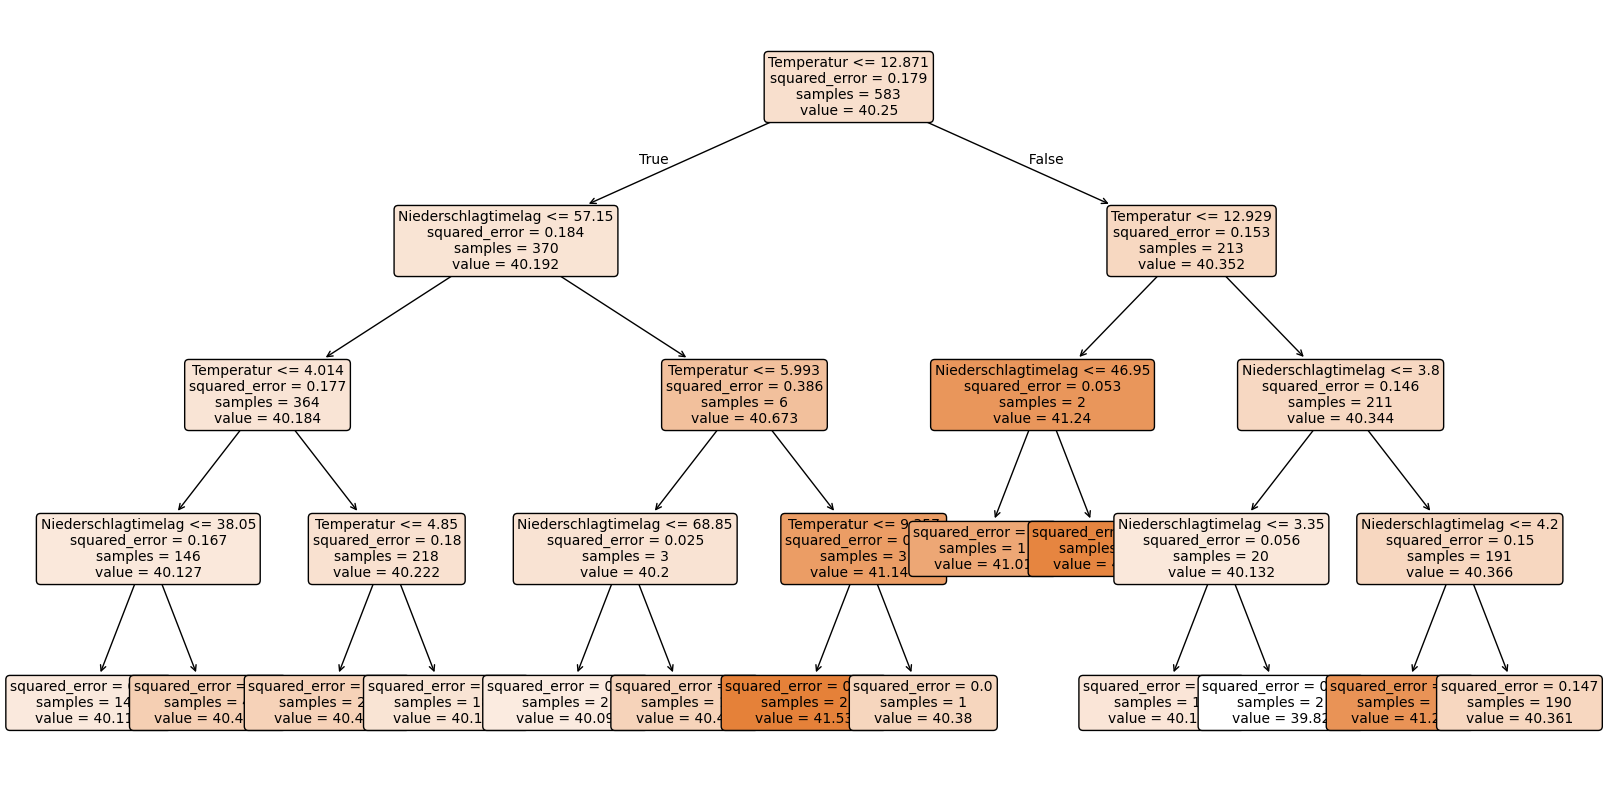

In [87]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.show()

In [88]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.16136716573211654


Gegenüberstellung des Decision Trees mit der 'Niederschlag'-Varialbe und einer Tiefe von 4 und des Decision Tree mit der *'Niederschlagtimelag'*-Variable und einer Tiefe von 4:

- Der insgesamte MSE von dem Decision Tree mit der *'Niederschlagtimelag'*-Variable ist mit 0.161 besser als 0.164.
- Der Decision Tree mit der *'Niederschlagtimelag'*-Variable nutzt darüber hinaus als erste Unterteilung "kleiner gleich 12.871 Grad" während der andere Decision Tree immer den Niederschlag als erste Unterteilungsvariable genutzt hat. Allerdings erhält der Decision Tree mit der *'Niederschlagtimelag'*-Variable eine breitere Unterteilung und damit ein deutlich detaillierteres Ergebnis.
- Das differenziertere Ergebnis des Decision Trees mit der *'Niederschlagtimelag'*-Variable ist auch darauf zurückzuführen, dass die *'Niederschlagtimelag'*-Variable eine breitere Spannweite an Werten hat. 

Insgesamt lässt sich der Grundwasserspiegel mit dem Decision Tree mit der *'Niederschlagtimelag'*-Variable am differenziertesten vorhersagen.